In [61]:
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import os
import scipy
import scipy.io as io
from PIL import Image
from skimage.transform import resize
from skimage.transform import rescale, resize, downscale_local_mean


In [37]:
vortall_mat = io.loadmat(os.path.join('.','DATA','VORTALL.mat'))
X = vortall_mat['VORTALL']

In [55]:
vortall_mat

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Mon Jan 28 19:23:11 2019',
 '__version__': '1.0',
 '__globals__': [],
 'VORTALL': array([[-5.92220e-15, -4.68318e-15, -2.94902e-15, ..., -9.62025e-15,
         -8.86421e-15, -7.27853e-15],
        [-6.01624e-15, -4.61205e-15, -2.58238e-15, ..., -9.57891e-15,
         -8.89550e-15, -7.31406e-15],
        [-5.92116e-15, -4.68413e-15, -2.50956e-15, ..., -9.98390e-15,
         -8.95430e-15, -7.50686e-15],
        ...,
        [-1.47386e-02, -5.92327e-03, -1.69510e-03, ..., -3.54696e-02,
         -3.64824e-02, -2.84128e-02],
        [-1.36956e-02, -5.31169e-03, -1.47472e-03, ..., -4.07780e-02,
         -3.80910e-02, -2.78294e-02],
        [-1.26353e-02, -4.73980e-03, -1.27796e-03, ..., -4.49435e-02,
         -3.89362e-02, -2.69284e-02]])}

In [38]:
X.shape


(89351, 151)

In [71]:

n = 449 
m = 199
nn = int(449/20)
mm = int(m/20)

In [94]:
M = X.shape[1]
Theta = np.zeros((3600, M ))
for k in range(M):
    temp = np.reshape(np.copy(X[:,k]), (n,m))
    tempSmall = rescale(temp, 0.2, anti_aliasing=True)
    Theta[:,k] = np.reshape(tempSmall, (3600,) )

In [95]:
## Renormalize Columns of Theta
normTheta = np.zeros(M)
for k in range(M):
    normTheta[k] = np.linalg.norm(Theta[:,k])
    Theta[:,k] = Theta[:,k]/normTheta[k]


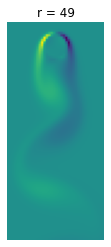

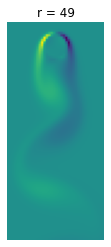

In [96]:
%matplotlib inline
import time
import pylab as pl
from IPython import display

for i in range(50):
    M = np.reshape(Theta[:,i], (90,40))
    plt.title('r = ' + str(i))
    plt.imshow(M)
    plt.axis('off')
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)

In [102]:
x1 = np.copy(X[:, 100])
testImage = np.copy(x1) + np.random.randn(*x1.shape)
tempp = np.reshape(np.copy(testImage), (n,m))
temppSmall = rescale(tempp, 0.2, anti_aliasing=True)
TestImage= np.reshape(temppSmall, (3600,) )

In [105]:
# L1 Minimum norm solution s_L1
def L1_norm(x):
    return np.linalg.norm(x,ord=1)

from scipy.optimize import minimize


In [110]:

eps = 0.01

constr = ({'type': 'ineq', 'fun': lambda x:  eps - np.linalg.norm(Theta @ x - TestImage,2)})

x0 = np.linalg.pinv(Theta) @ TestImage
res = minimize(L1_norm, x0, method = 'SLSQP', constraints = constr)
s = res.x

In [111]:
s

array([  -70258.92907584,    75844.46496858,  -885645.41506826,
        -337098.32899135,   408625.66123983,   383506.63889518,
        -191215.56826262,  1061244.04468469,    74242.43232394,
         146956.62271191,   341613.62335813, -1751360.53481782,
         749529.52505321,  -863128.1595752 ,  -591588.22811986,
        -578157.64591615,  -165839.23609282,  1059974.36040087,
         484034.28510768,   379367.43943085,  -807675.8799552 ,
         -43287.55415424,   -75969.99012922,   211939.27052959,
         206432.33935439,   754117.13276832, -1110265.41856217,
          80347.12646873,   183950.13033508,  -958290.57571223,
        -570076.65167763,   -84012.27774209,   875824.99608305,
         147009.51021324,   745573.66334669,   118540.28427926,
        -614286.66913684,  -283224.35797662,  -526415.42550177,
         -51081.61859729,  -443359.15679426,  -127312.28416198,
        -183561.25991507,  1357969.64317799,   867616.6717863 ,
         973516.98596383,  -299075.18127